# 🔰PyTorchでニューラルネットワーク基礎 #4.5 【画像分類・畳み込み層・可視化】

* [Qiitaの記事](https://qiita.com/AzukiImo/items/16e33d56fc1611c23a94)と連動しています
* ネットワークなどの基本構造はsample_04.ipynbと同一
* データファイル: aiueo.npz

## 「あいうえお」画像の分類とCNNの可視化
* CNNの出力結果を図として表示
* 活性化関数後の図
* カーネルの図

## 注意事項
* カーネルなどの画像は学習結果ごとに異なる画像となります

In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
#デバイスの選択
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using Device Name:", device)

Using Device Name: cuda:0


In [3]:
# 精度を計算する関数
def accuracy(y, t):
    _, argmax_list = torch.max(y, dim=1)
    accuracy = sum(argmax_list == t).item()/len(t)
    return accuracy

In [4]:
data = np.load("./aiueo.npz")
x = data["x"]
t = data["t"]

# torchテンソルに変換
x = torch.FloatTensor(x).to(device)
t = torch.LongTensor(t).to(device)

x, x_test, t, t_test = train_test_split(x,t, test_size=0.1, random_state=55)

In [5]:
x.shape, x_test.shape, t.shape

(torch.Size([712, 1, 28, 28]), torch.Size([80, 1, 28, 28]), torch.Size([712]))

## 確認ポイント
1. カーネルサイズと出力後の形状
2. out_channelsの効果
3. flatten
4. Linearのin_featuresの計算方法
5. 活性化関数の引数
   * nn.LeakyReLU()の場合は、\_\_init__ 内でオプションを指定
   * F.leaky_relu()の場合は、forward()で使うときに、 l_relu(h, negative_slope=0.01)と使用時にオプションを記入
     

In [6]:
##### モデル定義
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=5 ,kernel_size=5)
        self.act1 = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU導入
        self.flat = nn.Flatten()
        self.fc1 =  nn.Linear(in_features=5*24*24, out_features=100)
        self.act2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=5)
        
    def forward(self, x):
        h1 = self.cnn1(x)
        h2 = self.act1(h1)
        h = self.flat(h2)
        h = self.act2(self.fc1(h))
        y = self.fc2(h)
        return y, h1, h2

In [7]:
model = DNN()
model.to(device)

DNN(
  (cnn1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (act1): LeakyReLU(negative_slope=0.01)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2880, out_features=100, bias=True)
  (act2): ReLU()
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [8]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(model.parameters())

In [9]:
# 機械学習
LOOP = 150
for epoch in range(LOOP):
    optimizer.zero_grad()
    y,h1,h2 = model(x)
    loss = criterion(y, t)
    acc  = accuracy(y,t)
    loss.backward()
    optimizer.step()
    if (epoch+1)%10 == 0:
        print(f"{epoch}: loss: {loss.item()}, acc: {acc}")  # バッチ全体での損失や精度

9: loss: 0.9705981016159058, acc: 0.8665730337078652
19: loss: 0.47359585762023926, acc: 0.8946629213483146
29: loss: 0.3203161954879761, acc: 0.925561797752809
39: loss: 0.2322111874818802, acc: 0.9550561797752809
49: loss: 0.1676451861858368, acc: 0.9676966292134831
59: loss: 0.12163826823234558, acc: 0.9747191011235955
69: loss: 0.08802476525306702, acc: 0.9873595505617978
79: loss: 0.06314966827630997, acc: 0.9873595505617978
89: loss: 0.04541350528597832, acc: 0.9929775280898876
99: loss: 0.0330725759267807, acc: 0.9943820224719101
109: loss: 0.024589678272604942, acc: 0.9985955056179775
119: loss: 0.0187919232994318, acc: 1.0
129: loss: 0.014746072702109814, acc: 1.0
139: loss: 0.011849457398056984, acc: 1.0
149: loss: 0.009723514318466187, acc: 1.0


In [10]:
model.eval()
y_test,_,_ = model(x_test)
test_acc = accuracy(y_test, t_test)
print(f"精度:{test_acc}")

精度:0.95


## 特徴量の可視化

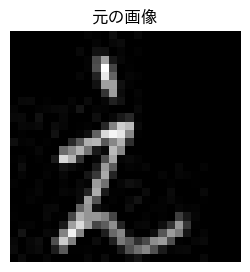

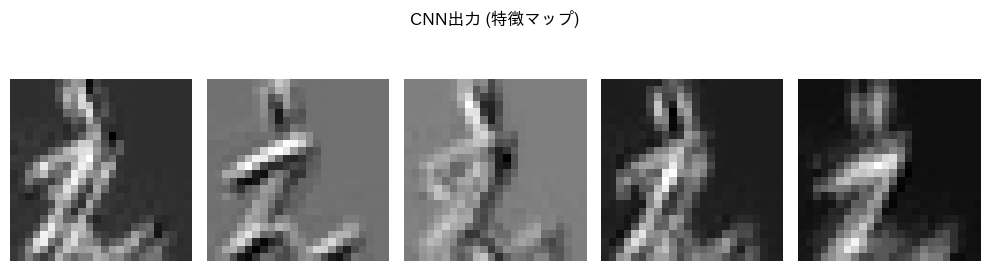

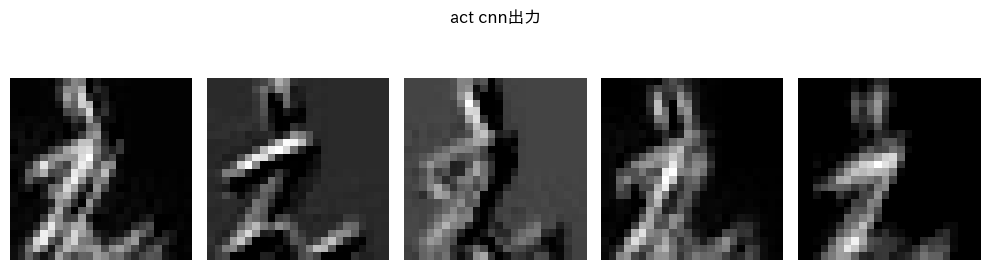

In [12]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# テスト用の一つの画像を選択
# あ：300, い：500　う：200 え：600　お:100
sample_image = x[600].unsqueeze(0)  # バッチ次元を追加 (1, 1, 28, 28)

# モデルを評価モードに
model.eval()

# 推論実行
with torch.no_grad():
    prediction, feature_map, act_feature_map = model(sample_image)
    
# 特徴マップのサイズは (1, 1, 24, 24) のはず
# バッチとチャネル次元を削除して2D画像として表示
feature_map = feature_map.squeeze().cpu().numpy()  # (24, 24)の2D配列に変換
act_feature_map = act_feature_map.squeeze().cpu().numpy()

# 元の画像と特徴マップを並べて表示
plt.figure(figsize=(3,3))
plt.title('元の画像')
plt.imshow(sample_image.squeeze().cpu(), cmap='gray')
plt.axis('off')
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(10, 3))
plt.suptitle('CNN出力 (特徴マップ)')
for i, ax in enumerate(axes):
    ax.imshow(feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(10,3))
plt.suptitle("act cnn出力")
for i, ax in enumerate(axes):
    ax.imshow(act_feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

### カーネルの可視化

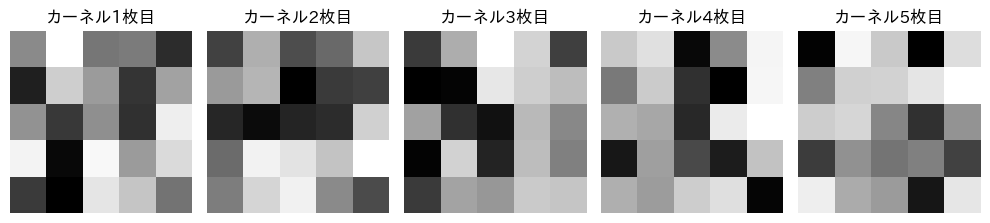

In [14]:
# カーネルの重みを取得
kernels = model.cnn1.weight.detach().cpu().numpy() # 形状は (1, 1, 5, 5)

fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(kernels[i].squeeze(), cmap='gray')
    ax.set_title(f'カーネル{i+1}枚目')
    ax.axis('off')
plt.tight_layout()
plt.show()